In [1]:
# install necessary packages
import os
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import ndimage

In [2]:
# options
image_path = "pennycress_pods/images/"
mask_path = "pennycress_pods/masks/"
image_save_path = "pennycress_pods/images_by_pod/"
mask_save_path = "pennycress_pods/masks_by_pod/"

# load image data
image_names = glob.glob(mask_path + "*.png")
image_names = [os.path.basename(x) for x in image_names]

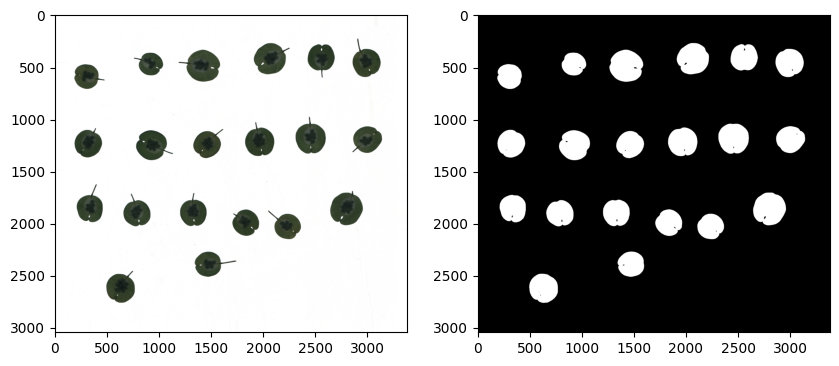

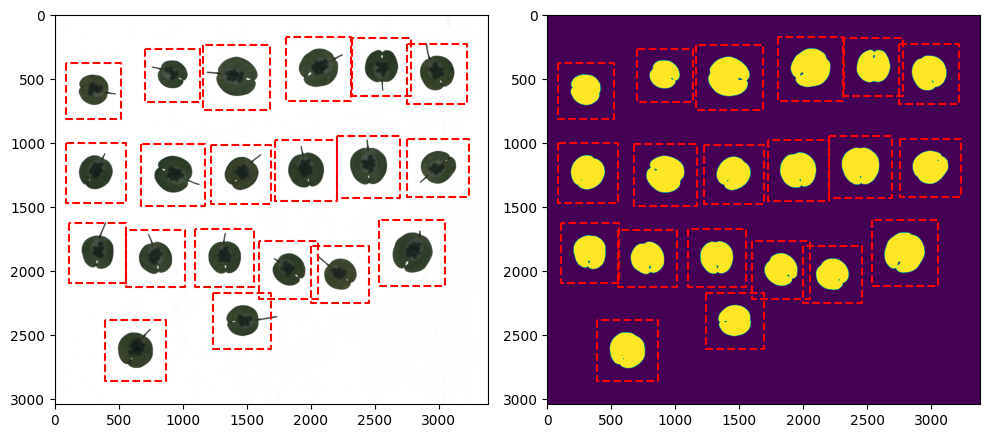

In [4]:

# create empty list for bounding boxes
bounding_boxes = []

# loop through each image
for image_name in image_names:

    # load image and mask
    image = Image.open(image_path + image_name).convert('RGB')
    mask = Image.open(mask_path + image_name).convert('RGB')

    # convert to numpy array and normalize
    image = np.array(image) / 255.0
    mask_rgb = np.array(mask) / 255.0 #normalized rgb mask for saving
    mask = np.array(mask).sum(axis=2) > 128 # convert to boolean mask

    # pad image and and mask
    image = np.pad(image, ((100, 100), (100, 100), (0, 0)), mode='edge')
    mask = np.pad(mask, ((100, 100), (100, 100)), mode='constant')
    mask_rgb = np.pad(mask_rgb, ((100, 100), (100, 100), (0, 0)), mode='constant')

    # plot image and mask for sanity
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(image)
    ax[1].imshow(mask, cmap='gray')
    plt.show()

    # label each component in mask and create bounding boxes
    labels = ndimage.label(mask)[0]
    bboxes = ndimage.find_objects(labels)

    # add padding to bounding boxes
    x_pad, y_pad = 100, 100
    for i in range(len(bboxes)):
        x, y = bboxes[i]
        bboxes[i] = slice(x.start-x_pad, x.stop+x_pad), slice(y.start-y_pad, y.stop+y_pad)

    # plot image and mask with bounding boxes
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(image)
    axs[1].imshow(mask)
    for bbox in bboxes:
        y, x = bbox
        axs[0].plot([x.start, x.start, x.stop, x.stop, x.start], [y.start, y.stop, y.stop, y.start, y.start], '--', color='r')
        axs[1].plot([x.start, x.start, x.stop, x.stop, x.start], [y.start, y.stop, y.stop, y.start, y.start], '--', color='r')
    plt.tight_layout()
    plt.show()

    # save split images
    for i, bbox in enumerate(bboxes):
        y, x = bbox
        split_image = image[y, x, :]
        split_mask = mask_rgb[y, x, :]

        # convert to PIL image
        split_image = Image.fromarray((split_image * 255).astype(np.uint8))
        split_mask = Image.fromarray((split_mask * 255).astype(np.uint8))

        # save img, msk
        split_image.save(image_save_path + image_name[:-4] + "_" + str(i) + ".png")
        split_mask.save(mask_save_path + image_name[:-4] + "_" + str(i) + ".png")